In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.9.0 
regionate version 0.5.3 
xwmt version 0.1.0 
xwmb version 0.5.5


In [5]:
import urllib.request
import shutil
import os

def download_MOM6_example_data(file_name):
    # download the data
    url = 'https://zenodo.org/record/15420739/files/'
    destination_path = f"../data/{file_name}"
    if not os.path.exists(destination_path):
        print(f"File '{file_name}' being downloaded to {destination_path}.")
        with urllib.request.urlopen(url + file_name) as response, open(destination_path, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f"File '{file_name}' has completed download to {destination_path}.")
    else:
        print(f"File '{file_name}' already exists at {destination_path}. Skipping download.")
    return destination_path

def load_MOM6_example_grid(file_name):
    destination_path = download_MOM6_example_data(file_name)
    ds = xr.open_dataset(destination_path, chunks=-1).fillna(0.)
    return construct_grid(ds)

def load_MOM6_coarsened_diagnostics():
    file_name = 'MOM6_global_example_sigma2_budgets_v0_0_6.nc'
    return load_MOM6_example_grid(file_name)

def construct_grid(ds):
    coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
        'Z': {'center': 'sigma2_l', 'outer': 'sigma2_i'},
    }
    boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}

    metrics = {('X','Y'):'areacello'}
    grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata=False)
    return grid

### Load example data and model grid

To keep this example dataset reasonably small while still providing accurate results, we have post-processed raw monthly-mean model outputs in the following ways:
- conservatively regridded all diagnostics from their original depth bins to density coordinates
- conservatively regridded from the native eddy-permitting grid (nominally 0.25º) to by a factor of 6x6 grid columns (nominally 1.5º)
- averaged over a year to further reduce the size of the dataset and suppress seasonal variations

In [6]:
grid = load_MOM6_coarsened_diagnostics()
display(grid)

File 'MOM6_global_example_sigma2_budgets_v0_0_6.nc' already exists at ../data/MOM6_global_example_sigma2_budgets_v0_0_6.nc. Skipping download.


<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='extend'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='extend'):
  * center   sigma2_l --> outer
  * outer    sigma2_i --> center

# Part 1. Global water mass budget

#### Collecting high-level budget terms

In [7]:
# Load MOM6 specific budget dictionary

import yaml
with open("./MOM6_global.yaml", "r") as stream:
    xbudget_dict = yaml.safe_load(stream)
xbudget.collect_budgets(grid, xbudget_dict)

#### Compute water mass budget

Terms in the budget are computed according to [Drake et al. (2025)](https://doi.org/10.1029/2024MS004383) for finely spaced density surfaces.

In [8]:
# specific tracer that defines the water mass
lam = "sigma2"

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Instantiate the water mass budget class
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict
    )

    wmb.mass_budget(lam, greater_than=True)
    wmt = wmb.wmt.squeeze()
    wmt.load()

#### Plot global water mass budget

The global water mass budget in density coordinates is given by:
\begin{equation}
\partial_{t} \mathcal{M}_{\geq} = \mathcal{G}^{(BF)}_{\geq} + \mathcal{G}^{(Mix)}_{\geq} + \mathcal{G}^{(Spu)}_{\geq} + \mathcal{S}_{\geq},
\end{equation}
where:
- $\partial_{t} \mathcal{M}_{\geq}(\sigma_{2}, t)$ quantifies the rate of change of global waters denser than $\sigma_{2}$

- $\mathcal{G}^{(BF)}_{\geq}$ quantifies the rate at which waters lighter than $\sigma_{2}$ transform into waters denser than $\sigma_{2}$ due to surface buoyancy fluxes (via heat, salt, or freshwater fluxes)

- $\mathcal{G}^{(Mix)}_{\geq}$ quantifies the rate at which waters lighter than $\sigma_{2}$ transform into waters denser than $\sigma_{2}$ due to surface buoyancy fluxes (via heat, salt, or freshwater fluxes)

- $\mathcal{G}^{(Spu)}_{\geq}$ quantifies the rate at which waters lighter than $\sigma_{2}$ transform into waters denser than $\sigma_{2}$ due to spurious numerical mixing. **Note:** This term cannot be explicitly computed and is thus indirectly inferred from the residual of all the other terms in the budget.

- $\mathcal{S}_{\geq}$ quantifies the rate at which surface freshwater fluxes add mass directly to a water mass. **Note:** This term is generally small and distinct from the effect that freshwater fluxes have on salinity (and hence density), which is instead included in $\mathcal{G}^{(BF)}_{\geq}$.



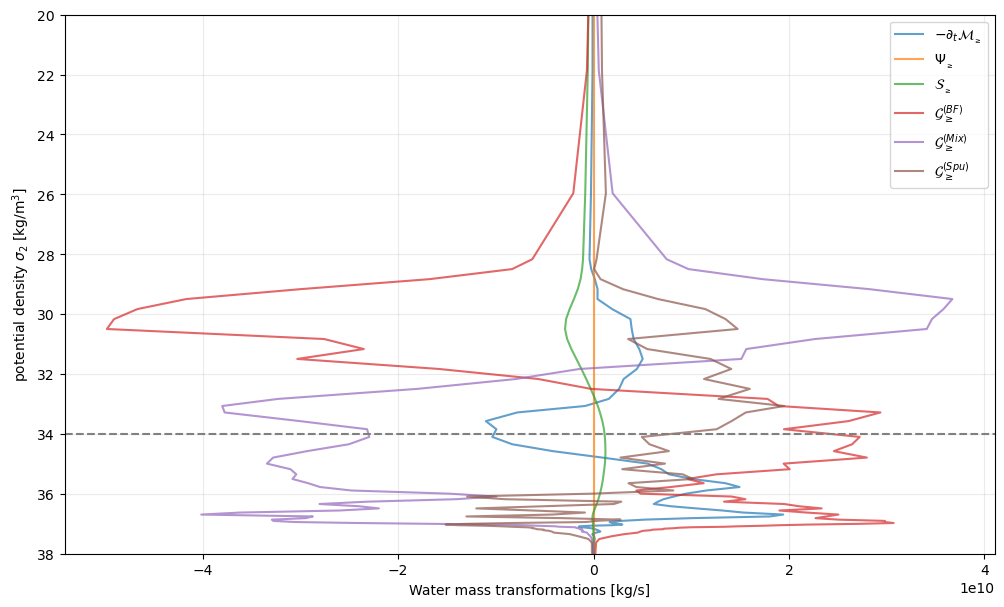

In [9]:
plt.figure(figsize=(12,7))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot(-wmt.mass_tendency,                wmt.sigma2_l_target, label=r"$-\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( 0.*wmt.sigma2_l_target,           wmt.sigma2_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.sigma2_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.sigma2_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
plt.axhline(34, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(38, 20);

#### Interpretation

Consider the mass budget for $\sigma_{2} = 34$ $\text{kg/m}^{3}$, highlighted by the dashed grey line in the figure above:

- Surface buoyancy loss (presumably at high latitudes) form dense waters at a rate of $\mathcal{G}^{(BF)}_{\geq} \simeq 2.5 \times 10^{10}$ kg/s.

- Interior mixing by various parameterized physical processes destroys dense waters at a rate of $\mathcal{G}^{(Mix)}_{\geq} \simeq 2.25 \times 10^{10}$ kg/s (by mixing them with lighter waters), nearly balancing the formation rate at the surface.

- A small amount of freshwater is directly added to dense water masses via surface mass fluxes, with a globally-integrated rate of $\mathcal{S}_{\geq} \simeq 10^{9}$ kg/s.

- Spurious numerical mixing associated with errors in the horizontal advection scheme or vertical advection scheme (Lagrangian remapping-regridding scheme) induce water mass transformations that are generally weaker than those due to parameterized mixing, but are not always of the same sign! We interpret the positive $\mathcal{G}^{(Spu)}_{\geq}$ at $\sigma_{2} = 34$ $\text{kg/m}^{3}$ to reflect spurious numerical entrainment in the overflows associated with North Atlantic Deep Water formation.

- The sum of dense water formation by surface buoyancy fluxes and spurious numerical entrainment is much larger than the rate of destruction by parameterized interior mixing, resulting in an imbalance that causes the mass of dense water to increase at a rate of $\partial_{t} \mathcal{M}_{\geq} \simeq 10^{10}$ kg/s.


#### On the attribution of the residual to spurious numerical mixing

While we have here interpreted the residual water mass transformations implied by the non-closure of the water mass budget as spurious numerical mixing, it is possible. However, in [Drake et al. (2025)](https://doi.org/10.1029/2024MS004383) we have performed sensitivity experiments to test several alternative error sources and found them to be either small or random, such that they can not explain the leading-order structure shown in the budget above.


# Part 2: Regional water mass budgets

### Example 1: specifying a region by its boundary

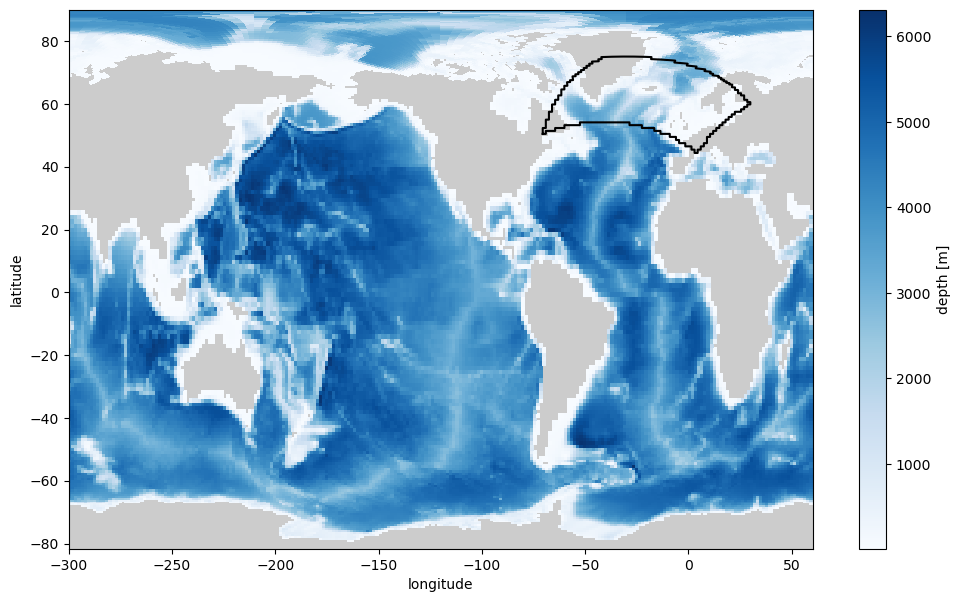

In [10]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "North Atlantic"
lons = np.array([-70, -40,  30,   5])
lats = np.array([ 50,  75,  60,  44])
region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(12,7))
plt.subplot(facecolor=(0.8, 0.8, 0.8))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'].where(grid._ds['deptho']!=0),
    cmap="Blues",
)
plt.colorbar(pc, label="depth [m]")
plt.plot(region.lons_c, region.lats_c, color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");

In [11]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict,
        region # specify the region
    )
    wmb.mass_budget(lam, greater_than=True)
    wmt = wmb.wmt.squeeze()
    wmt.load()

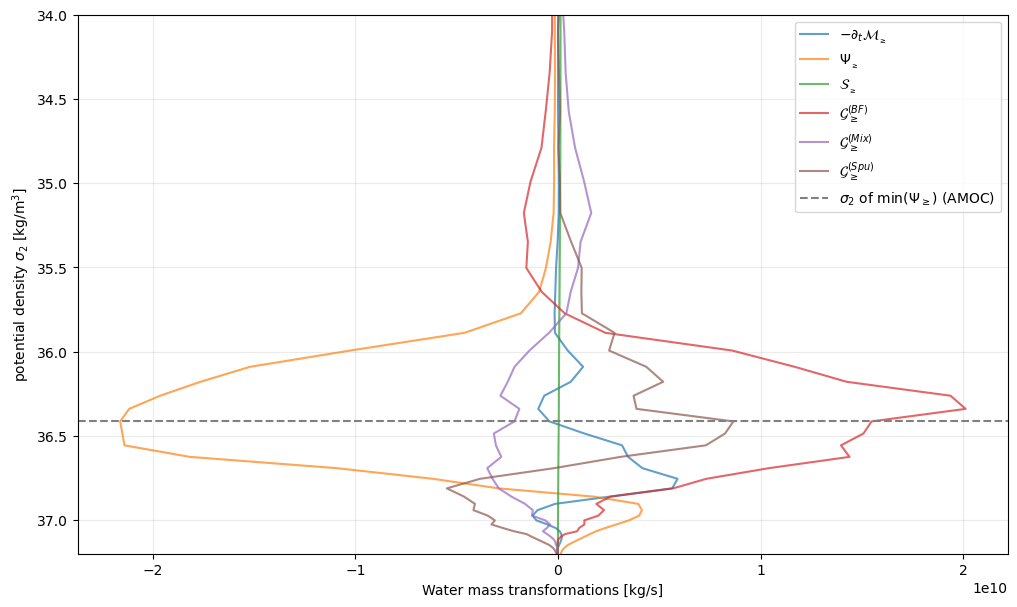

In [12]:
plt.figure(figsize=(12,7))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot(-wmt.mass_tendency,                wmt.sigma2_l_target, label=r"$-\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( wmt.convergent_mass_transport,    wmt.sigma2_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.sigma2_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.sigma2_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
plt.axhline(wmt.convergent_mass_transport.idxmin(), color="grey", linestyle="dashed", label="$\sigma_{2}$ of $\min(\Psi_{\geq})$ (AMOC)")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(37.2, 34);

### Example 2: specifying a region by its interior mask

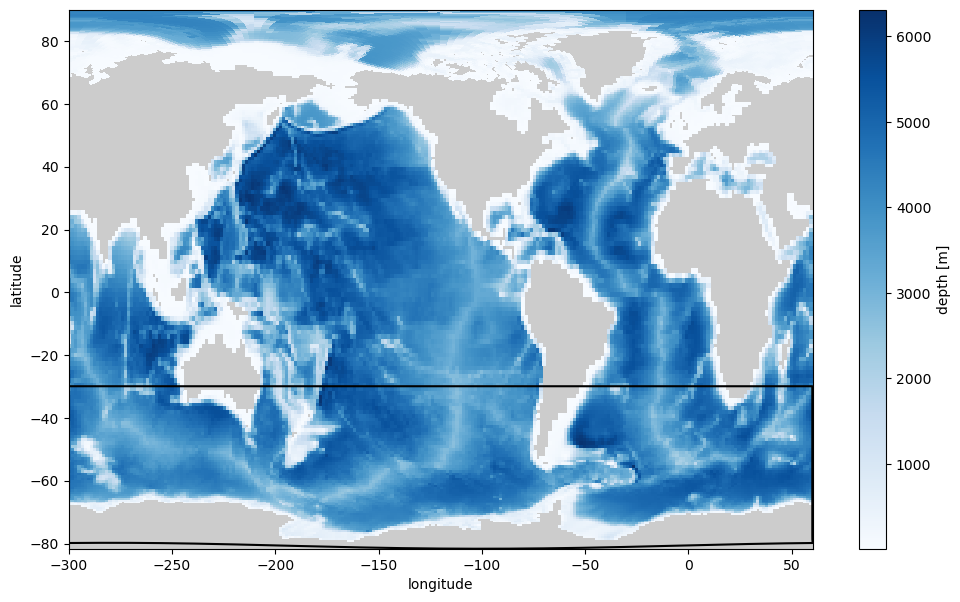

In [13]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "Southern Ocean"
mask = grid._ds.geolat < -30.
regions = regionate.MaskRegions(mask, grid, name) # returns a dictionary of all distinct region objects
region = regions.region_dict[0] # in this case, there is only one contiguous region

plt.figure(figsize=(12,7))
plt.subplot(facecolor=(0.8, 0.8, 0.8))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'].where(grid._ds['deptho']!=0),
    cmap="Blues",
)
plt.colorbar(pc, label="depth [m]")
plt.plot(region.lons_c, region.lats_c, color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");

In [14]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict,
        region # specify the region
    )
    wmb.mass_budget(lam, greater_than=True)
    wmt = wmb.wmt.squeeze()
    wmt.load()

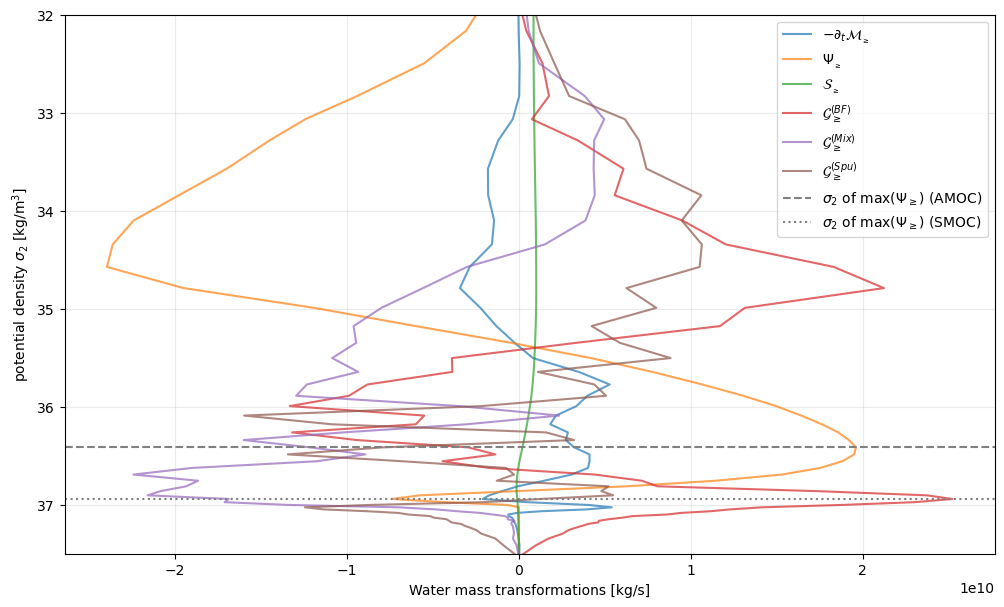

In [15]:
plt.figure(figsize=(12,7))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot(-wmt.mass_tendency,                wmt.sigma2_l_target, label=r"$-\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( wmt.convergent_mass_transport,    wmt.sigma2_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.sigma2_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.sigma2_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
sigma2_amoc = wmt.convergent_mass_transport.idxmax().compute()
sigma2_smoc = wmt.convergent_mass_transport.sel(sigma2_l_target=slice(sigma2_amoc, None)).idxmin().compute()
plt.axhline(sigma2_amoc, color="grey", linestyle="dashed", label="$\sigma_{2}$ of $\max(\Psi_{\geq})$ (AMOC)")
plt.axhline(sigma2_smoc, color="grey", linestyle="dotted", label="$\sigma_{2}$ of $\max(\Psi_{\geq})$ (SMOC)")


plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(37.5, 32);